# Лабораторная работа 3. Статистические гипотезы.

## Reading data and creating table of interval variational series (аналогично первой лабораторной работе)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [105]:
path_to_data = "data.xlsx"
df = pd.read_excel(path_to_data)
df.head()
writing_score = df['writing score'].copy()
reading_score = df['reading score'].copy()

writing_score.sort_values(inplace=True)
writing_score.reset_index(inplace=True, drop=True)
reading_score.sort_values(inplace=True)
reading_score.reset_index(inplace=True, drop=True)

writing_min = min(writing_score.min(), reading_score.min())
writing_max = max(writing_score.max(), reading_score.max())
writing_elements_count = writing_score.count()
writing_range = writing_max - writing_min 
writing_intervals_count = 15
writing_len_interval = writing_range / writing_intervals_count
writing_a = [writing_min + i*writing_len_interval for i in range(writing_intervals_count + 1)]
writing_indicates = writing_score.groupby(pd.cut(writing_score, writing_a, include_lowest=True)).count()
writing_indicates.name = 'indicates'
writing_frequency = writing_indicates / writing_elements_count
writing_frequency.name = 'frequency'
writing_hist = writing_frequency / writing_len_interval
writing_hist.name = "hist"
writing_points = [(writing_a[i] + writing_a[i + 1]) / 2 for i in range(writing_intervals_count)]
writing_F = writing_frequency.cumsum()
writing_F.name = 'F'
expect_writing_score = writing_points * writing_frequency
expect_writing_score.name = "expect"
expect_square_writing_score = (writing_points * writing_frequency) * writing_points
expect_square_writing_score.name = 'expect_square'

reading_min = min(writing_score.min(), reading_score.min())
reading_max = max(writing_score.max(), reading_score.max())
reading_elements_count = reading_score.count()
reading_range = reading_max - reading_min 
reading_intervals_count = 11
reading_len_interval = reading_range / reading_intervals_count
reading_a = [reading_min + i*reading_len_interval for i in range(reading_intervals_count + 1)]
reading_indicates = reading_score.groupby(pd.cut(reading_score, reading_a, include_lowest=True)).count()
reading_indicates.name = 'indicates'
reading_frequency = reading_indicates / reading_elements_count
reading_frequency.name = 'frequency'
reading_hist = reading_frequency / reading_len_interval
reading_hist.name = "hist"
reading_points = [(reading_a[i] + reading_a[i + 1]) / 2 for i in range(reading_intervals_count)]
reading_F = reading_frequency.cumsum()
reading_F.name = 'F'
expect_reading_score = reading_points * reading_frequency
expect_reading_score.name = "expect"
expect_square_reading_score = (reading_points * reading_frequency) * reading_points
expect_square_reading_score.name = 'expect_square'

## Проверка на однородность reading_score and writing_score с помощью критерия Смирнова

$$ D_{n,m}= \sup_{-\infty<x<\infty} |\hat{F}_{1n}(x) - \hat{F}_{2m}(x)| \text{ - статистика Колмогорова}$$
$$ 1 - K(\lambda_{\alpha}) = \alpha $$
$$ H_0 \text{ отвергается } \Leftrightarrow  D_{n,m} > \lambda_{\alpha}\sqrt{\frac{1}{n}+\frac{1}{m}} \text {  - Критерий однородности Смирнова-Колмогорова}$$
$$ \text {Эффективная формула для расчета статистики Колмогорова из книги Г.И.Ивченко, Ю.И.Медведев введение в математическую статистику.} $$
$$ D_{n,m}^+ = \max_{ 1\le s \le n}\left( \hat{F}_{2m}(X_{(s)}) - \frac{s-1}{n} \right) $$
$$ D_{n,m}^- = \max_{ 1\le s \le n}\left( \frac{s}{n} - \hat{F}_{2m}(X_{(s)}) \right) $$

In [109]:
from scipy.stats import kstwobign
from math import sqrt
def uniformity_ks_test(X, Y, F_X, F_Y, alpha):
    n = len(X)
    p_D = max([F_Y[X[i]] - (i - 1)/n for i in range(n)])
    n_D = max([i/n - F_Y[X[i]] for i in range(n)])
    D = (max(p_D, n_D))
    t = kstwobign.ppf(1 - alpha)
    return not sqrt(n)*D >= t*sqrt(1/len(X) + 1/len(Y))
uniformity_ks_test(reading_score, writing_score, reading_F, writing_F, 0.05)

False

Из теста Колмогорова-Смирнова следует, что выборки из разных распредлений

Text(0.5, 1.0, 'Sample distribution function')

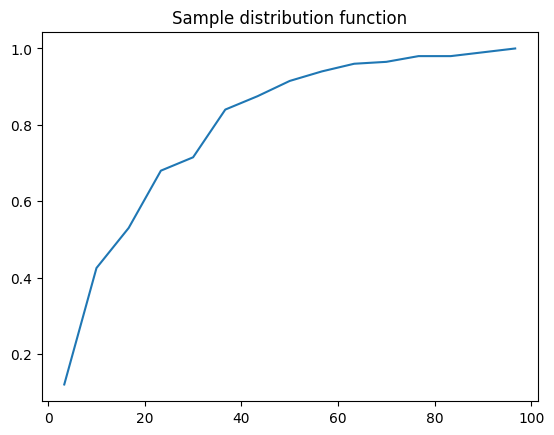

In [94]:
fig, ax = plt.subplots()
ax.plot(writing_points, writing_F.values)
ax.set_title('Sample distribution function')

Text(0.5, 1.0, 'Sample distribution function')

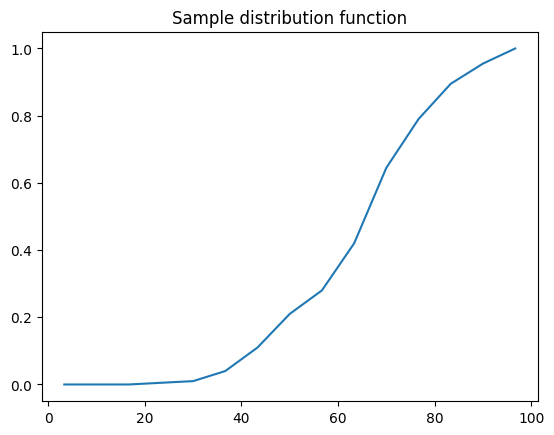

In [97]:
fig, ax = plt.subplots()
ax.plot(reading_points, reading_F.values)
ax.set_title('Sample distribution function')